In [2]:
import numpy
import pickle
import time

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, v_measure_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import pandas as pd

from torch.optim import SGD, Adam
from torch.utils.data import Dataset, DataLoader

import matplotlib
matplotlib.rcParams['figure.figsize'] = (9.0, 7.0)
from matplotlib import pyplot

In [3]:
# Load data from numpy file
# debinarizedData = numpy.load('debinarizedData.npy')
# numpy.shape(debinarizedData)

In [4]:
# Load data from pickle file

# infile = open('../Projet/trainDatasetPerdiem-20191028.pkl', 'rb')
# data, labels = pickle.load(infile)

# infile.close()

# data_numpy = data.to_numpy()
# print(labels)
# data.describe() # give column stats

# To one-hot-encode
# - Spécialité de médecins        | 33
# - Université de graduation      | 14
# - Plage horaire de facturation  | 3
# - Agence de représentation      | 845
# - Établissements                | 241

In [5]:
# Separate labeled and unlabeled data

# unlabeled = data_numpy[data_numpy[:, 1182] == -1][:, :-1]
# numpy.random.shuffle(unlabeled)
# numpy.save('unlabeled.npy', unlabeled)

# labeled = data_numpy[data_numpy[:, 1182] != -1]
# numpy.random.shuffle(labeled)
# numpy.save('labeled.npy', labeled)

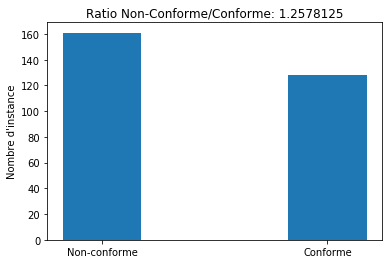

In [11]:
# Make smaller sample for testing

# unlabeled = numpy.load('unlabeled.npy')
# smaller_size = 5000
# smaller_unlabeled = unlabeled[:smaller_size]
# numpy.save('smaller_unlabeled.npy', smaller_unlabeled)

smaller_unlabeled = numpy.load('smaller_unlabeled.npy')
labeled = numpy.load('labeled.npy')

X, y = labeled[:, :-1], labeled[:, -1].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert Data to pytorch tensors
device = "cuda" if torch.cuda.is_available() else "cpu"
X_tensor = torch.from_numpy(X).float().to(device)
X_train_tensor = torch.from_numpy(X_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)
X_test_tensor = torch.from_numpy(X_test).float().to(device)
y_test_tensor = torch.from_numpy(y_test).float().to(device)

labels = ['Non-conforme', 'Conforme']

numberOfClass0 = len(y_test[y_test == 0])
numberOfClass1 = len(y_test[y_test == 1])
ratio = numberOfClass0/numberOfClass1

x = numpy.arange(len(labels))
width = 0.35

fig, subfig = pyplot.subplots()
subfig.bar(x, [numberOfClass0, numberOfClass1], width)

subfig.set_ylabel('Nombre d\'instance')
subfig.set_title(f'Ratio Non-Conforme/Conforme: {ratio}')
subfig.set_xticks(x)
subfig.set_xticklabels(labels)

pyplot.show()

In [12]:
def evalKmeans(X, y, k):
    kmeans = KMeans(n_clusters=k).fit(X)
    # Labels trouvé par le K-means
    cluster_labels = kmeans.labels_
    cluster_classes = []
    for c in range(k):
        # Labels réels du cluster
        cluster_ys = numpy.array(y[cluster_labels == c])
        # Classe la plus fréquente
        cluster_class = numpy.bincount(cluster_ys).argmax()
        cluster_classes.append(cluster_class)
    
    # Predictions des clusters
    y_pred = []
    for val in cluster_labels:
        y_pred.append(int(cluster_classes[val]))
    
    # Performance
    rand_perf = adjusted_rand_score(y, y_pred)
    mut_perf = adjusted_mutual_info_score(y, y_pred)
    v_perf = v_measure_score(y, y_pred)
    
    return((rand_perf, mut_perf, v_perf))

In [13]:
# Make dataset
class RAMQDatasetForAE(Dataset):
    
    def __init__(self, data, labels=None):
        super().__init__()
        self.data = []

        if not isinstance(labels, numpy.ndarray):
            labels = data
        dataset = list(zip(data, labels))
        
        for x, y in dataset:
            x = torch.Tensor(x.tolist())
            y = torch.Tensor([y])
            self.data.append((x, y))

    def __getitem__(self, index):
        return self.data[index]
    
    def __len__(self):
        return len(self.data)

In [14]:
# PARAMETRISED ENCODER AND DECODER

class Encoder(nn.Module):
    def __init__(self, dimensions, 
                 k_features, 
                 nb_layers=3,
                 activation=nn.ReLU(),
                 init=None,
                 dropout=None
                ):
        super().__init__()
        
        self.activation = activation
        self.init = init
        
        # Speed of reduction
        reduction_ratio = (k_features/dimensions)**(1/nb_layers)
        
        layers = []
        layer_lenght = dimensions
        
        # Calculate nb of layers and nb of neurons
        # Builds a list (ex:[1000, 500, 250, ... until k_features])
        # This list is half the network, aka encoder. Decoder will be
        # built using the inverse list 
        while layer_lenght > k_features:
            layers.append(layer_lenght)
            layer_lenght = int(layer_lenght*reduction_ratio)
        layers.append(k_features)
        
        # Build encoder layers
        encoder_layers = []
        for i, n_neurons in enumerate(layers[:-1]):
            if dropout:
                encoder_layers.append(nn.Dropout(dropout))
            layer = nn.Linear(layers[i], layers[i+1], bias=False)
            if init:
                init(layer.weight)
            encoder_layers.append(layer)
            encoder_layers.append(activation)
            
        # Save decoder structure for DecoderFromEncoder()
        self.decoder_layers_sizes = list(reversed(layers))
                                
        # Build pytorch sequential network
        self.encoder = nn.Sequential(*encoder_layers)
        
        
    def forward(self, x):
        x = self.encoder(x)
        return x
    
class DecoderFromEncoder(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        
        # Copy encoder hyperparams
        activation = encoder.activation
        
        # Array of decoder layer sizes calculated from encoder
        decoder_layers_sizes = encoder.decoder_layers_sizes
        # Pytorch nn layers of encoder
        encoder_layers = list(encoder.named_parameters())
        
        # Build decoder layers
        decoder_layers = []
        encoder_layers.reverse()
        for i, n_neurons in enumerate(decoder_layers_sizes[:-1]):
            layer = nn.Linear(decoder_layers_sizes[i], 
                              decoder_layers_sizes[i+1], bias=False)
            # Replace weights with those of encoder
            weights = encoder_layers[i][1].data.transpose(0,1)
            layer.weight.data = weights
            #layer.bias.data = bias
            # Add layer
            decoder_layers.append(layer)
            # Add activation
            decoder_layers.append(activation)
        
        # Build pytorch sequential network
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        x = self.decoder(x)
        return x    

In [15]:
# Source: https://discuss.pytorch.org/t/k-means-loss-calculation/22041/7
# Source: https://github.com/overshiki/kmeans_pytorch/blob/master/kmeans.py
class KMeansClusteringLoss(torch.nn.Module):
    def __init__(self, k, max_iter=100, tol=1e-2):
        super(KMeansClusteringLoss,self).__init__()
        self.k = k
        self.max_iter = max_iter
        self.tol = tol
        
    def calculate_dis(self, data1, data2):
        A = data1.unsqueeze(dim=1)
        B = data2.unsqueeze(dim=0)
        dis = (A-B)**2.0
        return dis.sum(dim=-1).squeeze()

    def forward(self, X):
        # Initialize k random cluster centers from X
        a = numpy.arange(X.shape[0])
        numpy.random.shuffle(a)
        centroids = X[a[:self.k]]
        
        # Get N and dimensions numbers
        n = X.shape[0]
        d = X.shape[1]
        
        # Format X to map with centroids
        z = X.reshape(n,1,d)
        z = z.repeat(1,self.k,1)
        
        # Loop to optimise clustering
        for i in range(self.max_iter):
            # Reshape centroids
            
            # Calculate distance of each point to each centroid
            dis = self.calculate_dis(X, centroids)
            # Find matching centroid for each X
            choice_cluster = torch.argmin(dis, dim=1).int()
            # Copy centroid for shift evaluation
            centroids_pre = centroids.clone()
            # Loop for every centroid
            for index in range(self.k):
                # Find the associated X to the cluster
                selected = torch.nonzero(choice_cluster==index).squeeze()
                selected = torch.index_select(X, 0, selected)
                
                # New Centroid is the avg of every points in it
                centroids[index] = selected.mean(dim=0)
            
            # Calculate shift of every centroid
            center_shift = torch.sum(torch.sqrt(torch.sum((centroids - centroids_pre) ** 2, dim=1)))
            
            if center_shift ** 2 < self.tol:
                break
                
        dis = self.calculate_dis(X, centroids)
        loss = (dis.min(dim=1)[0]**2).mean()
        return loss

In [16]:
# AE Training
# Pretrain autoencoder to minimise reconstruction loss 
# and keep model for clustering
def trainAutoEncoder(encoder, 
                     nb_epoch=5,
                     verbose=True, 
                     plot_loss=False,
                     cluster = False,
                     k_clusters = 10,
                     error_ratio = 0.6
                    ):
    
    # Setup cuda if available
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Training parameters 
    learning_rate = 0.02
    momentum = 0.9
    batch_size = 100
    if cluster:
        batch_size = max([100, k_clusters*5])
    
    # Load data set and create dataloader
    train_set = RAMQDatasetForAE(smaller_unlabeled)

    train_loader = DataLoader(train_set, batch_size=batch_size)

    # Load model and setup proper device
    encoder.to(device)

    # Reconstruction loss and optimzer
    rec_criterion = nn.MSELoss()
    clustering_criterion = KMeansClusteringLoss(k = k_clusters)
    optimizer = SGD(encoder.parameters(), lr=learning_rate, momentum=momentum)

    encoder.train()
    losses = []
    for i_epoch in range(nb_epoch):

        train_losses, cluster_perform = [], []
        if verbose and i_epoch%25==0:
            start_time = time.time()
        for i_batch, batch in enumerate(train_loader):
            # Ignore last batch if not full lenght
            if len(batch) != batch_size:
                # Read batch data
                x, y = batch

                # Create decoder for current encoder
                decoder = DecoderFromEncoder(encoder)
                decoder.to(device)
                decoder.train()

                # Freeze decoder weights 
                for name, param in decoder.named_parameters():
                    param.requires_grad = False

                # Reset gradients to zero
                optimizer.zero_grad()

                # Encode-decode
                encoded = encoder(x)
                decoded = decoder(encoded)

                # Reconstruction loss
                rec_loss = rec_criterion(decoded, x)
                # Clustering Loss
                if cluster:
                    clustering_loss = clustering_criterion(encoded)
                    # Total loss
                    loss = error_ratio*(rec_loss) + (1-error_ratio)*(clustering_loss)
                else:
                    loss = rec_loss

                # Backpropagate and gradient descent
                loss.backward()
                optimizer.step()
                train_losses.append(loss.item())
                progress = int(20*i_batch/len(train_loader))+1
                progress_bar = '='*progress + ' '*(20-progress)
                batch_perc = 100*i_batch/len(train_loader)

                print(f' [-] epoch {i_epoch:4}/{nb_epoch} | [{progress_bar}] {batch_perc:.2f}%, loss: {loss.item():.10f}', end='\r')
        mean_loss = numpy.mean(train_losses)
        losses.append(mean_loss)
        if verbose and i_epoch%25==0:
            print(' [-] epoch {:4}/{:}, train loss {:.6f} in {:.2f}s'.format(
                i_epoch, nb_epoch, mean_loss, time.time()-start_time))
    if plot_loss:
        pyplot.plot(losses)
        pyplot.title('Epoch Losses')
        pyplot.xlabel('Epoch')
        pyplot.ylabel('Loss')
        pyplot.show()

In [17]:
# function returns WSS score for k values from 1 to kmax
def calculate_WSS(points, kmax):
    sse = []
    K = numpy.linspace(1, 200, num=20).astype(int).tolist()
    for k in K:
        kmeans = KMeans(n_clusters = k).fit(points)
        centroids = kmeans.cluster_centers_
        pred_clusters = kmeans.predict(points)
        curr_sse = 0

        # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
        for i in range(len(points)):
            curr_center = centroids[pred_clusters[i]]
            curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2

        sse.append(curr_sse)
    return K, sse

def test_clustering(encoder):
    # Clustering elbow
    X_reduced = encoder(X_tensor).detach().numpy()
    x, sse = calculate_WSS(X_reduced, 200)
    pyplot.plot(x, sse)
    pyplot.title('Distance au carré entre les points et le centre de leur cluster')
    pyplot.xlabel('Nombres de cluster')
    pyplot.ylabel('Distance au carré')
    pyplot.show()

    # clustering eval
    K = numpy.linspace(2, 50, num=25).astype(int)
    rand_perfs, mut_perfs, v_perfs = [], [], []
    for k in K:
        rand_perf, mut_perf, v_perf = evalKmeans(X_reduced, y, k)
        rand_perfs.append(rand_perf)
        mut_perfs.append(mut_perf)
        v_perfs.append(v_perf)

    fig = pyplot.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(K, rand_perfs, label='Rand')
    ax.plot(K, mut_perfs, label='Inf. mutuelle')
    ax.plot(K, v_perfs, label='Mesure V')
    ax.legend()

    # Ajustement du grillage
    ticks = numpy.arange(0, 50, 1)
    ax.set_xticks(ticks, minor=True)
    ax.grid(which='minor', alpha=0.1)
    ax.grid(which='major', alpha=0.5)
    pyplot.show()

c:\users\alext\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Score on all dimensions: 0.8685121107266436 

Pretraining autoencoder:
 [-] epoch    0/200, train loss 0.041046 in 0.84s0%, loss: 0.0441980325
 [-] epoch   25/200, train loss 0.033956 in 0.84s0%, loss: 0.0384061933
 [-] epoch   50/200, train loss 0.033060 in 0.83s0%, loss: 0.0375902690
 [-] epoch   75/200, train loss 0.032626 in 0.77s0%, loss: 0.0371707045
 [-] epoch  100/200, train loss 0.032345 in 0.80s0%, loss: 0.0369346924
 [-] epoch  125/200, train loss 0.032155 in 0.80s0%, loss: 0.0365973003
 [-] epoch  150/200, train loss 0.031991 in 0.81s0%, loss: 0.0364000946
 [-] epoch  175/200, train loss 0.031888 in 0.77s0%, loss: 0.0363410711


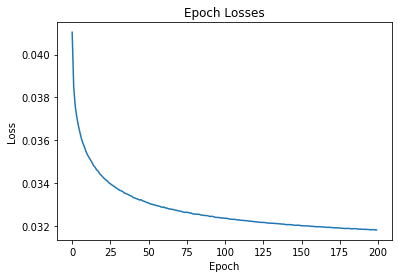

Full (1152, 1182)
Reduced (1152, 50)
Score on 50 dimensions (before clustering): 0.7162629757785467 



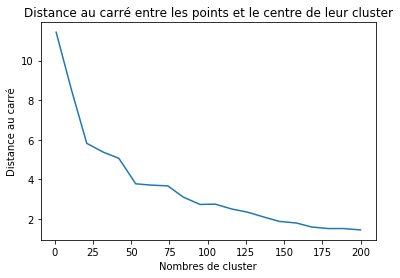

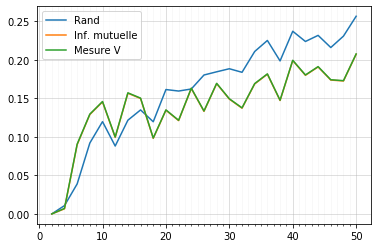

In [21]:
# Linear SVM performance with all dimensions
clf = LinearSVC()
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print("Score on all dimensions:", score, '\n')

# Input_dimensions length
input_d = numpy.shape(smaller_unlabeled)[1]
k_features = 50
nb_layers = 2

encoder = Encoder(dimensions=input_d,
                  k_features=k_features,
                  nb_layers=nb_layers,
                  activation=nn.ELU(),
                  init=nn.init.kaiming_normal_,
                  dropout=0.2
                 )

# pretrain on unlabeled data
print('Pretraining autoencoder:')
trainAutoEncoder(encoder, nb_epoch=200, verbose=True, plot_loss=True)

# Reduce dimensions on inputs
encoder.eval() 
X_train_reduced = encoder(X_train_tensor).detach().numpy()
X_test_reduced = encoder(X_test_tensor).detach().numpy()
print('Full', X_train.shape)
print('Reduced', X_train_reduced.shape)

# Train Linear SVM
clf = LinearSVC()
clf.fit(X_train_reduced, y_train)

# Calculate validation performance
score = clf.score(X_test_reduced, y_test)
print(f"Score on {k_features} dimensions (before clustering):", score, '\n')

# TEST CLUSTERING
test_clustering(encoder)

Optimising autoencoder for clustering:
 [-] epoch    0/25, train loss 0.080449 in 2.71s0%, loss: 0.0761554763


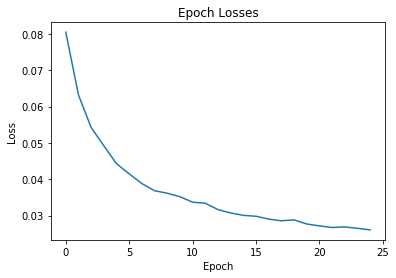

Score on 50 dimensions (after clustering): 0.7058823529411765


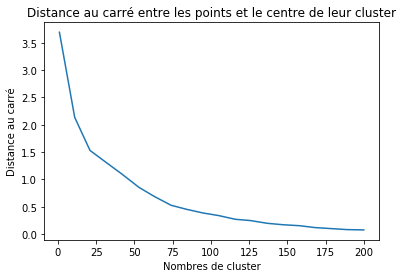

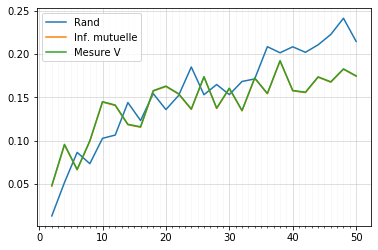

In [22]:

print('Optimising autoencoder for clustering:')
# encoder = Encoder(dimensions=input_d,
#                   k_features=k_features,
#                   nb_layers=nb_layers,
#                  )
trainAutoEncoder(encoder, nb_epoch=25, verbose=True, plot_loss=True, 
                 cluster=True,
                 k_clusters=50,
                 error_ratio = 0.5
                )

# Reduce dimensions on inputs
encoder.eval() 
X_train_reduced = encoder(X_train_tensor).detach().numpy()
X_test_reduced = encoder(X_test_tensor).detach().numpy()

# Train Linear SVM
clf = LinearSVC()
clf.fit(X_train_reduced, y_train)

# Calculate validation performance
score = clf.score(X_test_reduced, y_test)
print(f"Score on {k_features} dimensions (after clustering):", score)

# TEST CLUSTERING
test_clustering(encoder)

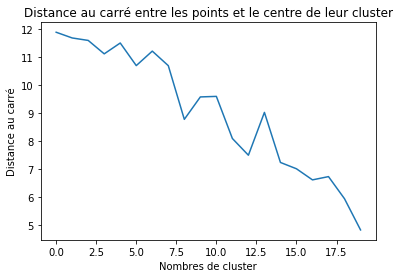

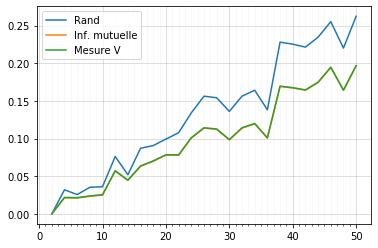

In [224]:
sse = calculate_WSS(X, 200)
pyplot.plot(sse)
pyplot.title('Distance au carré entre les points et le centre de leur cluster')
pyplot.xlabel('Nombres de cluster')
pyplot.ylabel('Distance au carré')
pyplot.show()

# clustering eval
K = numpy.linspace(2, 50, num=25).astype(int)
rand_perfs, mut_perfs, v_perfs = [], [], []
for k in K:
    rand_perf, mut_perf, v_perf = evalKmeans(X, y, k)
    rand_perfs.append(rand_perf)
    mut_perfs.append(mut_perf)
    v_perfs.append(v_perf)

fig = pyplot.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(K, rand_perfs, label='Rand')
ax.plot(K, mut_perfs, label='Inf. mutuelle')
ax.plot(K, v_perfs, label='Mesure V')
ax.legend()

# Ajustement du grillage
ticks = numpy.arange(0, 50, 1)
ax.set_xticks(ticks, minor=True)
ax.grid(which='minor', alpha=0.1)
ax.grid(which='major', alpha=0.5)
pyplot.show()

In [172]:
# # Compress labeled dataset
X_reduced = encoder(X_tensor).detach().numpy()
print(X_reduced.shape)
data_reduced = numpy.append(X_reduced, y_labeled.reshape((len(y_labeled), 1)), axis=1)
print(data_reduced.shape)
# # Save 
numpy.save(f'labeled_reduit_{k_features}dim.npy', data_reduced)
labeled = numpy.load('labeled_reduit_50dim.npy')
print(labeled.shape)

(1441, 20)
(1441, 21)
(1441, 51)


c:\users\alext\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


c:\users\alext\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


c:\users\alext\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


c:\users\alext\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


c:\users\alext\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


c:\users\alext\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


c:\users\alext\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


c:\users\alext\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


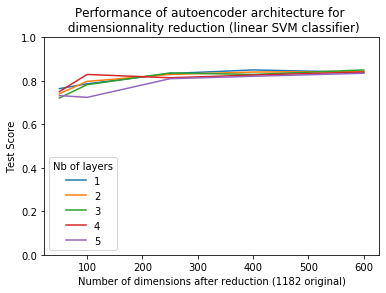

In [18]:
# ELU ACTIVATION and He init
# Test effect of number of k reduced dimensions
# and network depth
start_time = time.time()

# Input_dimensions length
input_d = numpy.shape(smaller_unlabeled)[1]

K = [600, 400, 250, 100, 50]
L = [1, 2, 3, 4, 5]

step = 1/(len(K)*len(L))

for i, l in enumerate(L):
    scores = []
    for j, k in enumerate(K):
        encoder = Encoder(dimensions=input_d, 
                            k_features=k, 
                            nb_layers=l,
                            activation=nn.ELU(),
                            init=nn.init.kaiming_normal_
                            dropout=0.5
                           )

        # train on unlabeled data
        trainAutoEncoder(encoder, verbose=False)
        
        # Reduce dimensions on inputs
        encoder.eval()
        X_train_reduced = encoder(X_train_tensor).detach().numpy()
        X_test_reduced = encoder(X_test_tensor).detach().numpy()
        
        # Train Linear SVM
        clf = LinearSVC()
        clf.fit(X_train_reduced, y_train)
        
        # Calculate validation performance
        score = clf.score(X_test_reduced, y_test)
        scores.append(score)
        
        # Display progress
        progress = 100*((step*(i)*len(K))+(step*(j+1)))
        print(f'[ {progress:.0f}% ] {l} layers, {k} features, score: {(100*score):.2f}% | {(time.time()-start_time):.1f}s \t', end='\r')
    
    pyplot.plot(K, scores, label=f'{l}')
    
pyplot.title(f'Performance de l\'architecture d\'autoencodeurs pour \n la réduction de dimentionnalité')
pyplot.ylabel('Score Test')
pyplot.ylim(0, 1)
pyplot.xlabel(f'Nombre de dimensions après réduction ({input_d} original)')
pyplot.legend(title="Nb de couches")
pyplot.show()

In [ ]:
# AE clustering optimisation
# Must retrain the autoencoder from pretrained weights
# now optimising weights to minimise clustering loss
# AND reconstruction loss
